# Do small share of police really draw a third of complaints?
    
[This FT article](https://www.ft.com/content/141182fc-7727-4af8-a555-5418fa46d09e) from 2012 claimed police complaints in various US cities were disproportionally concentrated among the top 10% of police officers with the most complaints. During my internship in the summer 2022 I was asked to replicate these findings using a dataset on police complaints in London Metrpolitan Police (MET). The code below will demonstrate the statistical reasons for why it is impossible to drawn these kinds of conclusions from this type of data.


![title](https://raw.githubusercontent.com/veronikasamborska1994/data_analysis_example_OWD/master/figures/FT_2021.png)


In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from utils import *
%matplotlib inline
default_plotting_params()

### Load data on Metropolitan Police complaints between 2017-2022 obtained under a freedom of information request by the reporters at FT

Note that without doing any further analyses we can already quickly see a major issue with this dataset. The data file contains 2 columns: case reference and the id of the officer involved. There is no information on the number of cases that each officer had worked on. This means that some officers might receive more complaints than others simply because they work on more cases, and not because they are more likely to receive a complaint. 





In [2]:
case_ref, officer_id = load_police_data()

## Data Inspection Step

First, as a sanity check, we will simply visualise the data to ensure there are no issues that stand out. The function `inspect_data` in `utils.py` orders the officers based on how many complaints they received. After simply plotting each officer's total number of complaints we can see that there is a very unrealistic outlier with over 8000 complaints over the past 5 years. This means subject 122060 was on average receiving 4 complaints per day for the past 5 years – which seems impossible. The second most complained officer ID is called 'Organisational', which is unlikely to refer to a single officer. We will therefore exclude these officer IDs from the rest of the analysis.

subject 122060 has an average of 4 complaints per day
Organisational has an average of 0.24 complaints per day


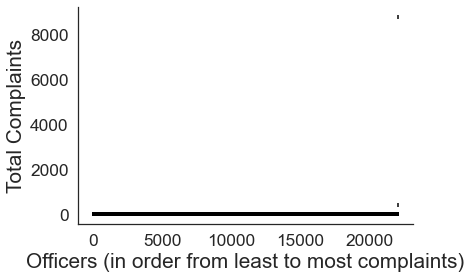

In [3]:
sorted_cases, sorted_ids  = inspect_data(officer_id)

plt.scatter(np.arange(len(sorted_cases)),sorted_cases, color = 'black', marker = "|", s = 10); sns.despine()
plt.xlabel('Officers (in order from least to most complaints)'); plt.ylabel('Total Complaints')

print(str(sorted_ids[-1]) + ' has an average of ' + str(int(sorted_cases[-1]/5/365)) + ' complaints per day')
print(str(sorted_ids[-2]) + ' has an average of ' + str(np.round(sorted_cases[-2]/5/365,2)) + ' complaints per day')

sorted_cases_cl = sorted_cases[:-2]; sorted_ids_cl = sorted_ids[:-2] # exclude the last two subjects


## Grouping officers ranked by the number of complaints into deciles 

Here I will group the MET officers into deciles just like in the original article. It looks like we are more or less replicating the results that top 10% of the officers are drawing a disproportionate amount of complaints. As mentioned earlier, we do not have a baseline for how many cases each officer worked on so this plot is confounded and should not be interpreted as 'top % of officers are disproportionally more likely to receive complaints'. For the next step, let's assume (although this is likely to be an oversimplification) that each officer has a uniform probability of receiving a complaint. 

In MET top 10% of the officers are responsible for 28% of complaints ?


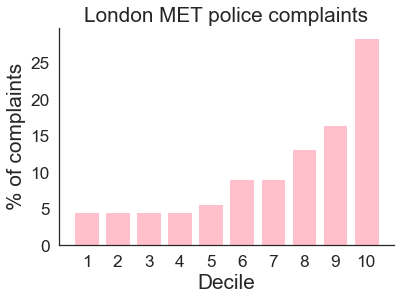

In [4]:
deciles_ = get_decile_data(sorted_cases_cl, sorted_ids_cl)

plt.bar(np.arange(len(deciles_)), deciles_, color = 'pink')
plt.xticks(np.arange(10),np.arange(10)+1); plt.title('London MET police complaints')
plt.ylabel( '% of complaints'); plt.xlabel('Decile'); sns.despine()
print('In MET top 10% of the officers are responsible for ' +str(int(deciles_[-1])) + '% of complaints ?')

## Simulation for a case where all officers have an equal probability of receiving a complaint

We can quickly find out that there are [32,493](https://en.wikipedia.org/wiki/Metropolitan_Police) officers at the London MET and from our dataset we can calculate that there were 58,147 complaints received in the past 5 years. So on average each year there were 0.36 complaints per officer. With these two numbers we can simulate the simplest case where each officer has an equal probability of receiving a complaint by drawing samples from a Poisson distribution (because complaints are discrete numbers) with an expected number of 0.36 per year. 

In [5]:
n_total_officers = 32493;  # from https://en.wikipedia.org/wiki/Metropolitan_Police
tot_complaints = np.sum(sorted_cases) # total number of complaints 
unif_prob = tot_complaints/n_total_officers/5 # assume each officer has a uniform probability of a complaint (divided by 5 because the data is from the last 5 years)
print('Total # of complaints ' + str(tot_complaints)); print(str(np.round(unif_prob,2)) + ' complaints per officer')   

prob_, deciles_sim = simulate_decile_data(unif_prob, tot_complaints, n_total_officers)


Total # of complaints 58129
0.36 complaints per officer


## Even if all officers were equally likely to receive a complaint the resulting distribution would look exponential 

In simulated data where all officers have an equal chance of getting a complaint the top decile is responsible for a lower number of complaints (20%) than in the real data (28%) but the distribution still looks exponential. This suggests that there is a major problem in interpreting these kinds of plots.

Top 10% of the officers are responsible for 21% of complaints in simulated data


<Figure size 720x360 with 0 Axes>

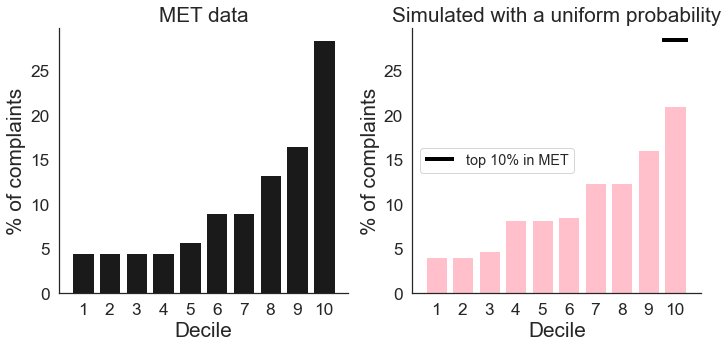

In [6]:
colors = ['k','pink']; titles = ['MET data', 'Simulated with a uniform probability']; 
max_ = np.max([deciles_,deciles_sim]) # % of complaints in the top decile (MET data)

plt.figure(figsize = (10,5)); fig, ax = plt.subplots(1,2, figsize=(10, 5))
for i, pl in enumerate([deciles_,deciles_sim]):
    ax[i].bar(np.arange(len(pl)), pl, color = colors[i])
    ax[i].set_xticks(np.arange(10),np.arange(10)+1)
    ax[i].set_ylabel( '% of complaints'); ax[i].set_xlabel('Decile')
    ax[i].set_title(titles[i]);  sns.despine()
   
    
ax[1].hlines(max_,8.5,9.5, color = 'black', label = 'top 10% in MET', linewidth = 4); plt.legend(loc ='center left', fontsize = 'large'); plt.tight_layout()

print('Top 10% of the officers are responsible for ' +str(int(deciles_sim[-1])) + '% of complaints in simulated data')

## Simulating a case where the probabilities of receiving a comlaint in each decile are proportional to the ratios in % of complaints received in each decile in MET data

Now let's simulate a case where each decile of police officers has a different chance of receiving a complaint. Here the probability distribution is proportional to the distribution of the % of complaints in each decile in the MET data. Officers in the top decile will on average have at least one complaint a year. The resulting simulated distribution starts to match the real data much more closely. This suggests it is in fact possible that some officers are more likely to receive a complaint than others. 

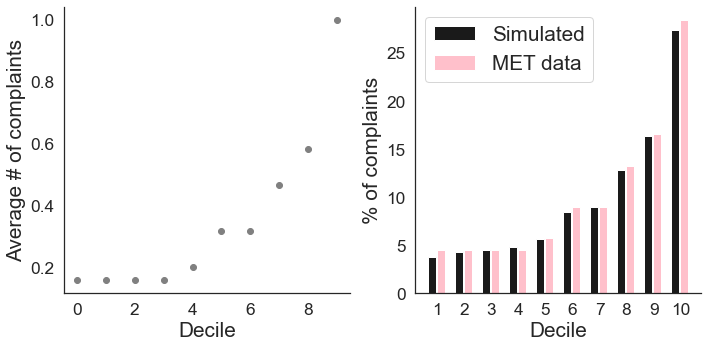

In [7]:
complaint_probs = deciles_/np.max(deciles_) # set the probability distribution to be proportional to the distribution of the % of complaints in each decile in the MET data.
quartiles = int(n_total_officers/10) # divide total # of officers into a 10 quartiles 
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].scatter(np.arange(len(complaint_probs)), complaint_probs, color = 'grey'); plt.xticks(np.arange(10),np.arange(10)+1)
ax[0].set_ylabel('Average # of complaints'); ax[0].set_xlabel('Decile');

simulated_, years_to, av  = simulate_non_uniform(complaint_probs,quartiles)
legends = ['Simulated', 'MET data']
colors = ['k','pink'];  plt.subplot(1,2,2)
for i, pl in enumerate([simulated_,deciles_]):
    ax[1].bar(np.arange(len(pl))+i/3, pl, color = colors[i], label = legends[i], width = 0.3); 
    ax[1].legend()
    ax[1].set_ylabel( '% of complaints'); ax[1].set_xlabel('Decile'); ax[1].set_xticks(np.arange(10)+0.2, np.arange(10)+1)

sns.despine(); plt.tight_layout()

## Major issue

As we do not know the baseline number of cases each officer has worked on from our data we cannot actually assume that the probabilities of receiving a comlaint in each decile are proportional to the ratios in % of complaints received in each decile. So let's model some other probability distributions of complaints across officers and see what the resulting % of complaints per decile plot looks like. We can use a beta distribution (with shape parameters a and b) to generate various probability distributions of complaints. In the first example below we 


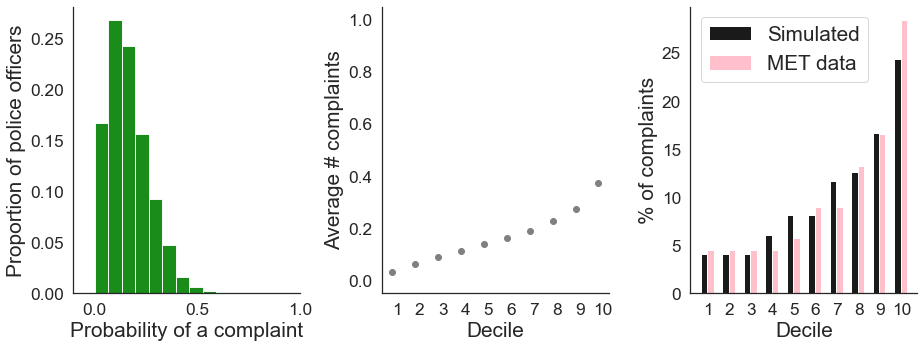

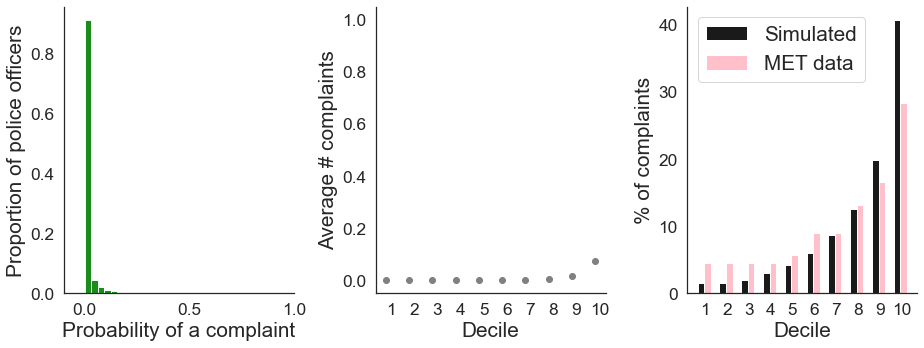

In [8]:
a_ex = [2,0.1]; b_ex = [10, 10] # beta shape parameters examples 
quartiles = int(n_total_officers/10) # divide total # of officers into a 10 quartiles 

for a,b in zip(a_ex,b_ex): # zip through examples and plot
    lamdas = beta_distr(a, b, quartiles) 
    yearly_prob = sort_lambdas(lamdas)
    simulated, years_to, av = simulate_non_uniform(lamdas,quartiles)
    fig, ax = plt.subplots(1,3, figsize=(13, 5))
    ax[2].bar(np.arange(len(simulated)), simulated, color = 'k', label = 'Simulated',  width = 0.3)
    ax[2].bar(np.arange(len(deciles_))+0.3, deciles_, color = 'pink', label = 'MET data', width = 0.3)
    ax[2].legend()
    ax[2].set_ylabel( '% of complaints'); ax[2].set_xlabel('Decile'); ax[2].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    weights = np.ones_like(lamdas) / len(lamdas)
    ax[0].hist(lamdas, 10,weights = weights, color = 'green', alpha = 0.9)
    ax[0].set_xlim(-0.1,1)
    ax[0].set_xlabel('Probability of a complaint'); ax[0].set_ylabel('Proportion of police officers')
    ax[1].scatter(np.arange(len(yearly_prob)), yearly_prob, color = 'grey');
    ax[1].set_ylabel('Average # complaints'); ax[1].set_xlabel('Decile'); ax[1].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    ax[1].set_ylim(-0.05,1.05)
    plt.tight_layout()
    sns.despine()

## Interactive

The widget below allows you to play around with various distributions of probabilities of complaints

In [9]:
@widgets.interact(a = (0.1,10),b = (0.1, 10)) # ranges of a and b parameters of the beta distribution can be amended here
def plot(a = 0.1, b = 2):
    quartiles = int(n_total_officers/10) # divide total # of officers into a 100 quartiles to reduce code running time 
    lamdas = beta_distr(a,b, quartiles)
    yearly_prob = sort_lambdas(lamdas)
    simulated, years_to,av = simulate_non_uniform(lamdas,quartiles)
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax[2].bar(np.arange(len(simulated)), simulated, color = 'k', label = 'Simulated',  width = 0.3)
    ax[2].bar(np.arange(len(deciles_))+0.3, deciles_, color = 'pink', label = 'MET data', width = 0.3)
    ax[2].legend()
    ax[2].set_ylabel( '% of complaints'); ax[2].set_xlabel('Decile'); ax[2].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    weights = np.ones_like(lamdas) / len(lamdas)
    ax[0].hist(lamdas,weights = weights, color = 'green', alpha = 0.9)
    ax[0].set_xlim(-0.1,1)
    ax[0].set_xlabel('Probability of getting a complaint'); ax[0].set_ylabel('Proportion of police officers')
    ax[1].scatter(np.arange(len(yearly_prob)), yearly_prob, color = 'grey');
    ax[1].set_ylabel('Average # of complaints'); ax[2].set_xlabel('Decile'); ax[1].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    
    ax[1].set_ylim(-0.05,1.05)
    sns.despine(); plt.tight_layout()
    

    print("Top decile responsible for " + str(np.round(simulated[-1],1)) + '%')
    print('Number of years to achieve total # of complaints --> ' + str(years_to))
    print('Average % of complaints per officer ' + str(np.round(av,3))+ '%')

    


interactive(children=(FloatSlider(value=0.1, description='a', max=10.0, min=0.1), FloatSlider(value=2.0, descr…

## Simulation of various probability distributions

Now, let's simulate various probability distributions programmatically. The probability distribution of complaints across officers will affect the average number of complaints per year, which will in turn affect the number of years it would take to achieve a total of 58,147 complaints. We will store these variables here to later explore if there is a relationship between these variables and the % of complaints received in the top decile.

In [16]:
run = False # set to True to run the simulation otherwise loads pre-calculated values

path_to_rep = '/Users/veronikasamborska/Desktop' # edit path to your local copy of the repository
if run:
    shape_prms = np.arange(0.1, 20, 0.1); # a and b shape parameters ranges and step size  
    decile_responsible, average_complaints, years_to_total,labmdas_dec = simulate_lambdas(shape_prms)
else: # load values from simulation
    sim_vals  = np.load(path_to_rep +'/data_analysis_example_OWD/simvals.npy')
    decile_responsible = sim_vals[0]; average_complaints = sim_vals[1]; years_to_total = sim_vals[2]
    labmdas_dec = np.load(path_to_rep +'/data_analysis_example_OWD/lambdas.npy')

##  Probability distributions with an average probability of complaints that matches the data 

We can now look at the possible % values of complaints accounted by the top decile under various probability distributions. First, we can select values from simulations that would approximate some of the known conditions in our data - it took 5 years for the MET to achieve a total # of complaints 58129 and there was an average of 0.36 complaints per officer. We can see that under these conditions higher averages in complaints in the the top decile will result in the top percentile accounting for a higher proportion of all complaints. 

However, this is accompanied by the fact that complaints in the bottom 90 % of the officers will decrease as the number of average complaints in the top decile increases. We can also estimate total yearly complaints under different


Text(0.5, 1.0, 'Top decile mean')

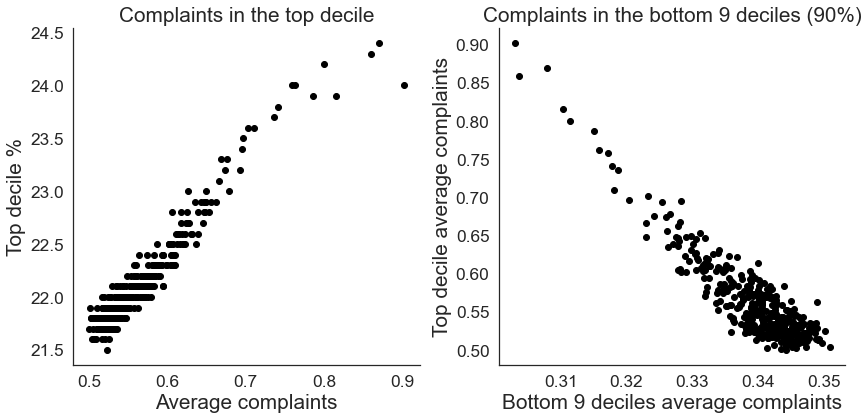

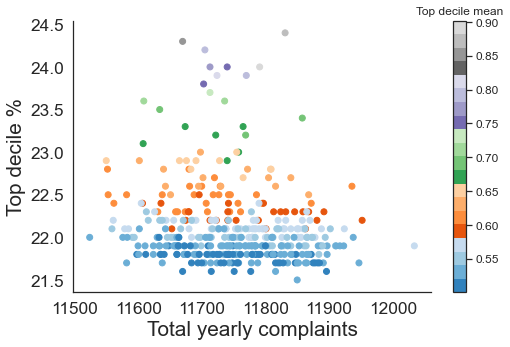

In [17]:
# Selecting average # of complaints to be 0.36 and # of years to complaint to be equal to 5
year_av_data = np.intersect1d(np.where(np.round(average_complaints,2) == 0.36)[0], np.where(years_to_total == 5)[0])
select_prop = labmdas_dec[year_av_data]; select_dec = decile_responsible[year_av_data]
fig, ax = plt.subplots(1,2, figsize=(12, 6))

ax[0].scatter(select_prop[:,-1], select_dec, color = 'black')
ax[0].set_ylabel('Top decile %'); ax[0].set_xlabel('Average complaints'); ax[0].set_title('Complaints in the top decile')
ax[1].scatter(np.mean(select_prop[:,:-1],1), select_prop[:,-1], color = 'black')
ax[1].set_ylabel('Top decile average complaints'); ax[1].set_xlabel('Bottom 9 deciles average complaints'); ax[1].set_title('Complaints in the bottom 9 deciles (90%)')
sns.despine(); plt.tight_layout()

total_cases = []
dec_officers = 0.1*n_total_officers
for prob in select_prop:
    bottom_dec = np.zeros(9); bottom_dec[:] = dec_officers
    bottom_dec_sum = int(np.sum(bottom_dec*prob[:-1]))
    top_dec_sum = int(dec_officers*prob[-1])
    total_cases.append(bottom_dec_sum+top_dec_sum)
plt.figure(figsize =(8,5)); plt.scatter(total_cases,select_dec, c = select_prop[:,-1], cmap = 'tab20c')
plt.xlabel('Total yearly complaints'); plt.ylabel('Top decile %'); sns.despine()
cl = plt.colorbar(); cl.ax.tick_params(labelsize = 12) 
cl.ax.set_title('Top decile mean', fontsize = 12)


##  % of complaints received in the top decile increases exponentially as the average complaints in the police force decrease 

Finally, let's plot the % of complaints accounted by the top decile from all of our simulated probability distributions of complaints. Overall, there is a negative exponential relathionship between % of complaints received in the top decile and the rates of police complaints.

This means that high % of cases accounted by the top decile can also mean that the police force is in fact receiving fewer complaints. 


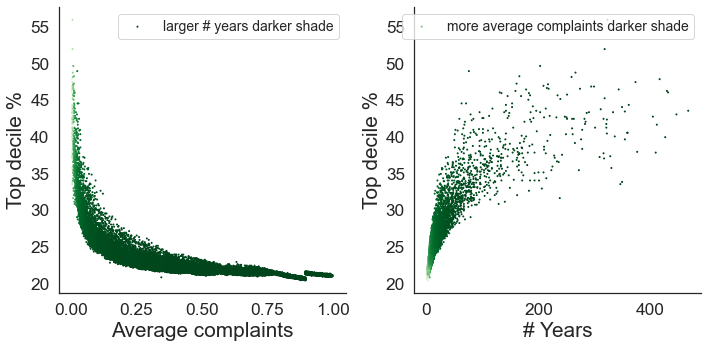

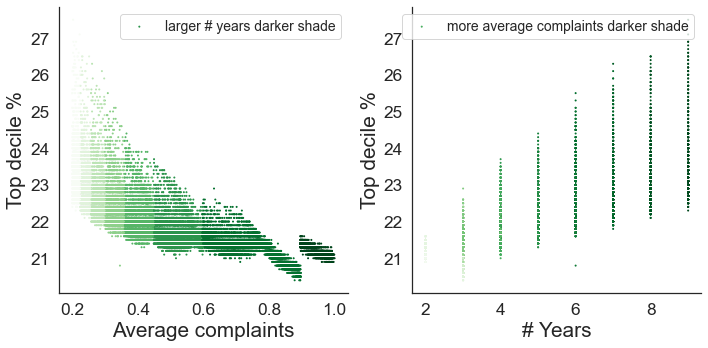

In [18]:
ind_year_all = np.arange(len(years_to_total)); 
ind_year_20 = np.where(years_to_total < 10)[0]
to_plot = [average_complaints, years_to_total]; labels = ['larger # years darker shade','more average complaints darker shade',]
for year_ind in [ind_year_all,ind_year_20]:
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    xlabel = ['Average complaints', '# Years']
    for i,pl in enumerate(to_plot):

        ax[i].scatter(pl[year_ind], decile_responsible[year_ind],c = to_plot[i-1][year_ind], cmap='Greens_r', s = 1, 
                     label = labels[i])
        
        ax[i].set_xlabel(xlabel[i]); ax[i].set_ylabel('Top decile %')
        
        plt.tight_layout(); sns.despine()
        ax[i].legend(fontsize = 14)
    